# Binary Classification of Insurance Selling

The aim of this workbook is train a model to predict whether customers respond positively to an automobile insurance offer.

url: https://www.kaggle.com/competitions/playground-series-s4e7/overview

# Lib Imports

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [42]:
RANDOM_STATE = 32
Y_COLUMN = 'Response'

In [43]:
import os

TRAIN_DATASET_DIR = '/kaggle/input/playground-series-s4e7/train.csv' if os.path.exists('/kaggle/input/') else 'train.csv'
TEST_DATASET_DIR = '/kaggle/input/playground-series-s4e7/test.csv' if os.path.exists('/kaggle/input/') else 'test.csv'

print(f"train dataset dir: {TRAIN_DATASET_DIR}")
print(f"test dataset dir: {TEST_DATASET_DIR}")

train dataset dir: /kaggle/input/playground-series-s4e7/train.csv
test dataset dir: /kaggle/input/playground-series-s4e7/test.csv


## 1. EDA

### 1.1 Train and Test Dataset Loading

The aim of this section is to load the train and test datasets, in order to investigate missing data and general trends.

In [44]:
train_df = dd.read_csv(TRAIN_DATASET_DIR)

In [45]:
train_df = train_df.compute()

In [46]:
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [47]:
test_df = dd.read_csv(TEST_DATASET_DIR)
test_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148


Train Data Null and Dtype checks

In [48]:
train_df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [72]:
train_df[Y_COLUMN].value_counts(normalize=True)

Response
0    0.877003
1    0.122997
Name: proportion, dtype: float64

There is a clear bias in this dataset which will need to be address with under / over sampling.

In [49]:
train_df.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

Test Data Null and Dtype checks

In [50]:
test_df.isna().sum().compute()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

There doesn't seem to be any missing or unusual data so we can proceed with the EDA of the training Dataset.

### 1.2 Train Dataset Feature Engineering

The first step is to analyse the current dataset to determine if features can be engineered. For starters, I'm going to investigate the object columns to determine whether they can be encoded.

In [51]:
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [52]:
train_df['Gender'].value_counts()

Gender
Male      6228134
Female    5276664
Name: count, dtype: int64

There are only two values so these can be binary encoded.

In [53]:
train_df['Vehicle_Age'].value_counts()

Vehicle_Age
1-2 Year     5982678
< 1 Year     5044145
> 2 Years     477975
Name: count, dtype: int64

There are only three unique values for Vehicle Age, so these can also be encoded.

In [54]:
train_df['Vehicle_Damage'].value_counts()

Vehicle_Damage
Yes    5783229
No     5721569
Name: count, dtype: int64

Finally Vehicle Damage can also be binary encoded.

So to summarize, all of the object columns can be encoded. Vehicle Damage and Gender will be Binary Encoded, and Vehicle Age will be one hot encoded.

In [55]:
BINARY_COLS = ['Gender', 'Vehicle_Damage']
ONE_HOT_COLS = ['Vehicle_Age']

In [56]:
label_binarizer = LabelBinarizer()

In [57]:
train_df['Gender'] = train_df['Gender'].apply(lambda x: 0 if x == 'Male' else 1)
train_df['Vehicle_Damage'] = train_df['Vehicle_Damage'].apply(lambda x: 1 if x == 'Yes' else 0)

In [58]:
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,0,21,1,35.0,0,1-2 Year,1,65101.0,124.0,187,0
1,1,0,43,1,28.0,0,> 2 Years,1,58911.0,26.0,288,1
2,2,1,25,1,14.0,1,< 1 Year,0,38043.0,152.0,254,0
3,3,1,35,1,1.0,0,1-2 Year,1,2630.0,156.0,76,0
4,4,1,36,1,15.0,1,1-2 Year,0,31951.0,152.0,294,0


In [59]:
vehicle_age_one_hot = pd.get_dummies(train_df['Vehicle_Age'])

In [60]:
train_df = pd.concat([train_df.drop('Vehicle_Age', axis=1), vehicle_age_one_hot], axis=1)
train_df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,1-2 Year,< 1 Year,> 2 Years
0,0,0,21,1,35.0,0,1,65101.0,124.0,187,0,True,False,False
1,1,0,43,1,28.0,0,1,58911.0,26.0,288,1,False,False,True
2,2,1,25,1,14.0,1,0,38043.0,152.0,254,0,False,True,False
3,3,1,35,1,1.0,0,1,2630.0,156.0,76,0,True,False,False
4,4,1,36,1,15.0,1,0,31951.0,152.0,294,0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131515,11504793,0,48,1,6.0,0,1,27412.0,26.0,218,0,True,False,False
1131516,11504794,1,26,1,36.0,0,1,29509.0,152.0,115,1,False,True,False
1131517,11504795,1,29,1,32.0,1,0,2630.0,152.0,189,0,False,True,False
1131518,11504796,1,51,1,28.0,0,1,48443.0,26.0,274,1,True,False,False


### 1.3 Numerical Col Analysis

The next step is to review the distribution of numerical columns

In [61]:
NUMERICAL_COLS = ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Region_Code'}>],
       [<Axes: title={'center': 'Annual_Premium'}>,
        <Axes: title={'center': 'Policy_Sales_Channel'}>],
       [<Axes: title={'center': 'Vintage'}>, <Axes: >]], dtype=object)

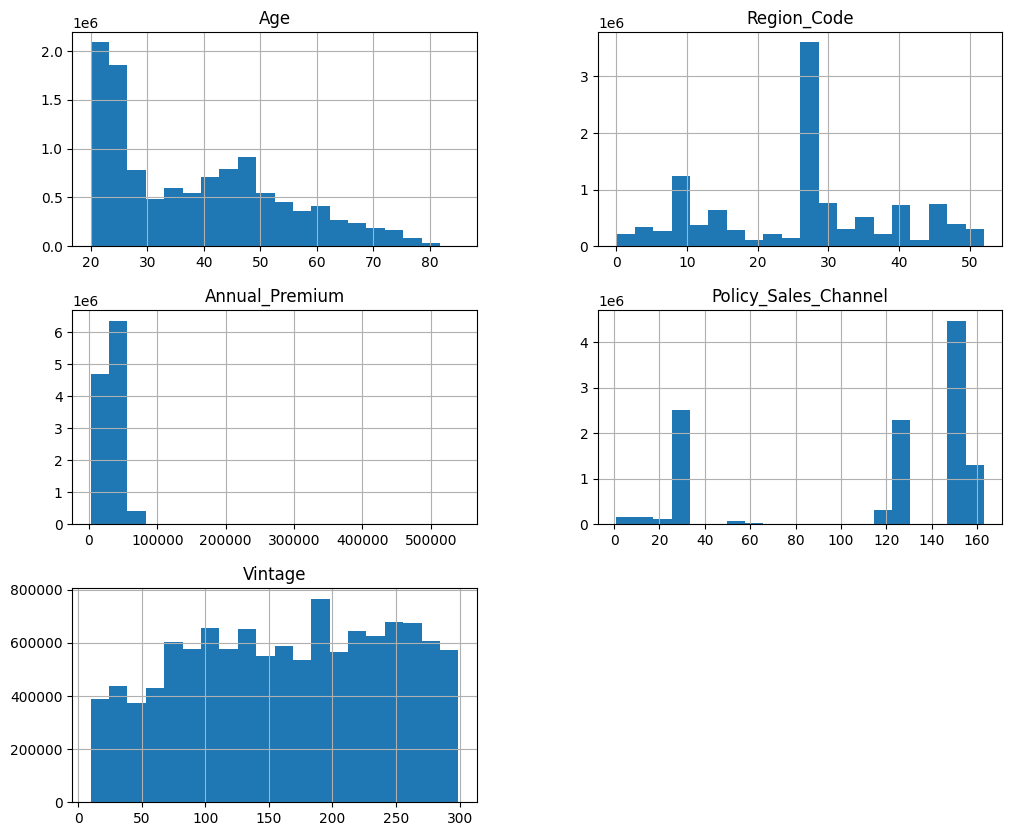

In [62]:
train_df_full[NUMERICAL_COLS].hist(bins=20, figsize=(12, 10))

Given the above distributions, it may be worth normalizing these columns.

### 1.4 Target vs Feature Analysis

The next step is to review the distribution of the Target Variable, and investigate the relationship between the rest of the features prior to model training.

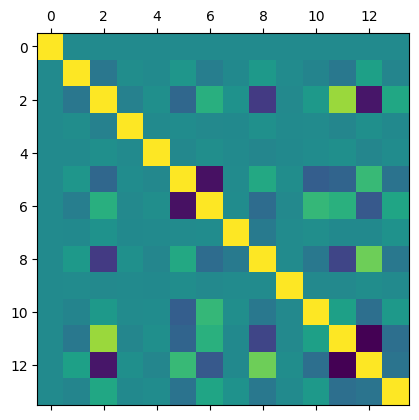

In [63]:
plt.matshow(train_df_full.corr())
plt.show()

## 2. Pipeline Definition and Train Test Split

Define the preprocessors used for numerical, one hot and binary data.

In [64]:
numerical_transformer = Pipeline(
    steps=[
        ('ss', StandardScaler())
    ]
)

In [65]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, NUMERICAL_COLS)
    ]
)

In [66]:
X = train_df.drop(Y_COLUMN, axis=1)
y = train_df[Y_COLUMN]

In [67]:
lr_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegressionCV(Cs=10, cv=4, penalty='l2', random_state=RANDOM_STATE))
    ]
)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

## 3. Initial Model Training and Evaluation

In [69]:
lr_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['Age', 'Region_Code',
                                                   'Annual_Premium',
                                                   'Policy_Sales_Channel',
                                                   'Vintage'])])),
                ('classifier', LogisticRegressionCV(cv=4))])

In [70]:
y_pred = lr_model.predict(X_test)

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93   3027134
           1       0.00      0.00      0.00    424306

    accuracy                           0.88   3451440
   macro avg       0.44      0.50      0.47   3451440
weighted avg       0.77      0.88      0.82   3451440



## 4. Addressing Data Bias with Under / Over Sampling